# SIAH YAO LIANG TP061861
# Optimizing Speech Emotion Recognition in Call Centres using Advanced Deep Learning Techniques

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
!pip install tables
import os.path

import matplotlib.pyplot as plt  #EDA
import seaborn as sns

import librosa                  #Visual speech
!pip install librosa
from librosa import display

from IPython.display import Audio # display audio

from joblib import Parallel, delayed  #For parrallel
from tqdm.notebook import tqdm

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import Callback , EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout ,GRU , BatchNormalization
from sklearn.model_selection import StratifiedKFold
# from keras import optimizers
from tensorflow.keras import regularizers, optimizers

!pip install keras-tuner
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import load_model

from sklearn.metrics import confusion_matrix, classification_report  # evaluation



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 11.0 MB/s eta 0:00:00


<ipython-input-5-521b0be569d0>:30: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import Crema dataset

In [ ]:
Crema_path = Path("/content/drive/MyDrive/FYP/Speech_emotion_recognition/Crema")


In [ ]:
filepaths = list(Crema_path.glob(r'**/*.wav'))
labels = list(map(lambda x: os.path.split(x)[1].split('_')[2], filepaths))
set(labels)

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

audio_df = pd.concat([filepaths, labels], axis=1)
audio_df
audio_df.to_csv("speech_imported_dataset.csv")

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/FYP/Speech_emotion_recognition/code /speech_imported_dataset.csv")
df = df.drop(columns=[df.columns[0]])
df.shape

(7442, 2)

# Exploratory Data Analysis

<ipython-input-9-d1f335e2e521>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Label', data=df, palette='viridis')


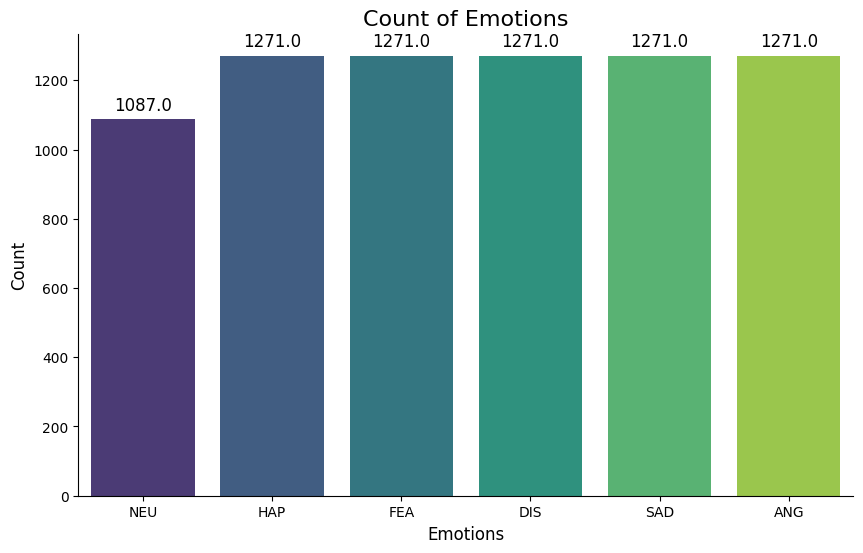

In [ ]:

# df is dataframe , label is emotion
plt.figure(figsize=(10, 6))
plt.title('Count of Emotions', size=16)
sns.countplot(x='Label', data=df, palette='viridis')
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)

# Add Value on each bar
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=12)

sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()


# Visualization Speech

In [ ]:
from re import X
def create_waveplot_aug (data ,sr ,e):
  plt.figure(figsize=(10, 3))
  plt.title('Waveplot for {} Audio'.format(e), size=16)
  display.waveshow(data, sr=sr)
  plt.show()

def create_waveplot (data ,sr ,e):
  plt.figure(figsize=(10, 3))
  plt.title('Waveplot for {} emotion'.format(e), size=16)
  display.waveshow(data, sr=sr)
  plt.show()

def create_spectrogram (data ,sr ,e):
  X = librosa.stft(data)
  Xdb = librosa.amplitude_to_db(abs(X))
  plt.figure(figsize=(11, 3))
  plt.title('Spectrogram for {} emotion'.format(e), size=16)
  librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
  plt.colorbar()

# ANGRY

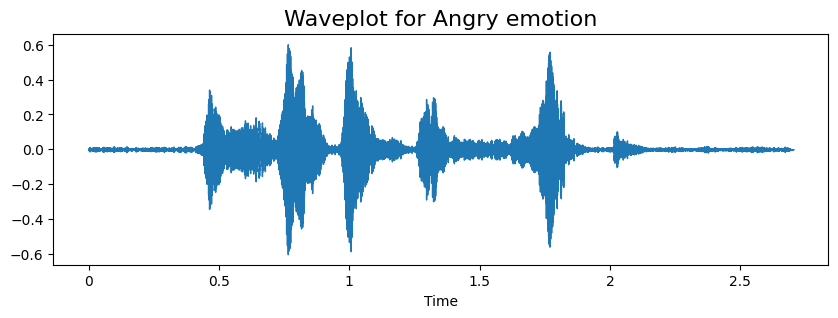

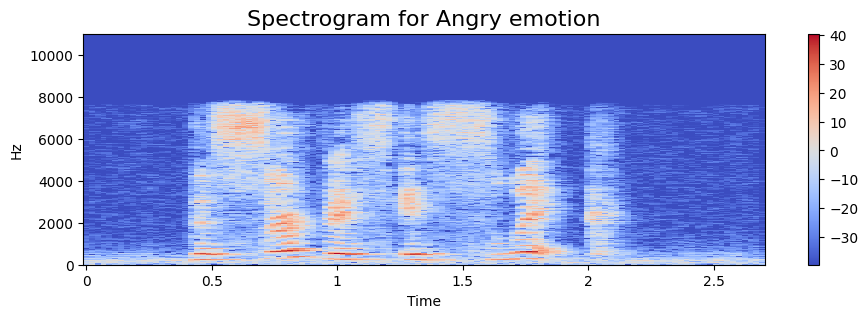

In [ ]:
emotion='ANG'
word_to_display = "Angry"
path = np.array(df.Filepath[df.Label==emotion])[0]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, word_to_display)
create_spectrogram(data, sampling_rate, word_to_display)
Audio(path)

# SAD

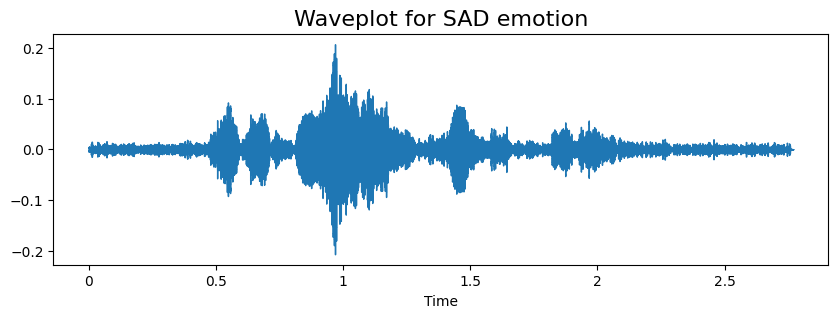

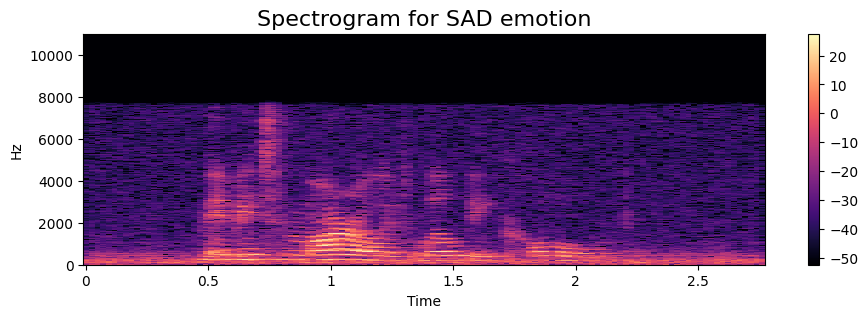

In [ ]:
emotion='SAD'
path = np.array(df.Filepath[df.Label==emotion])[0]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

# DISGUST

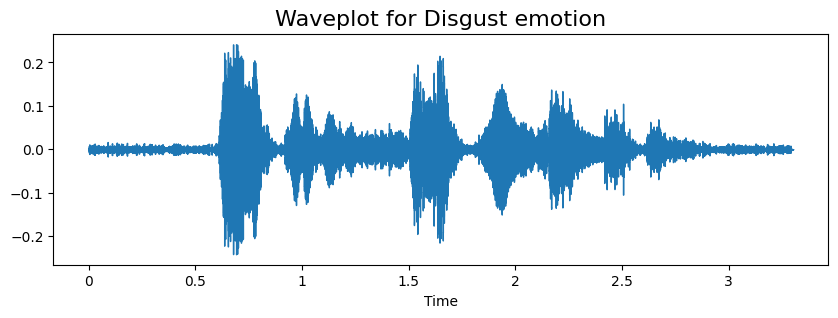

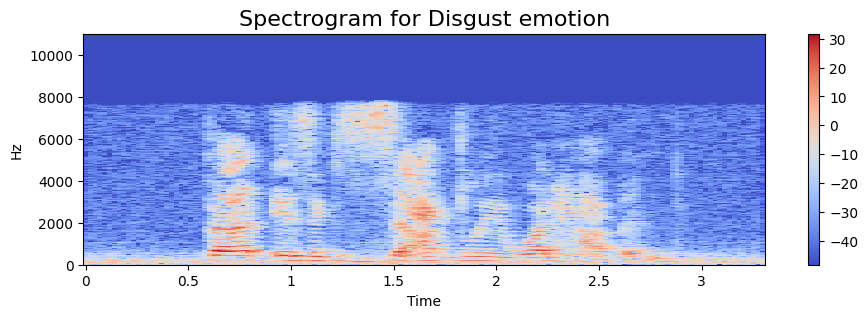

In [ ]:
emotion='DIS'
word_to_display = "Disgust"
path = np.array(df.Filepath[df.Label==emotion])[0]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, word_to_display)
create_spectrogram(data, sampling_rate, word_to_display)
Audio(path)

# FEAR

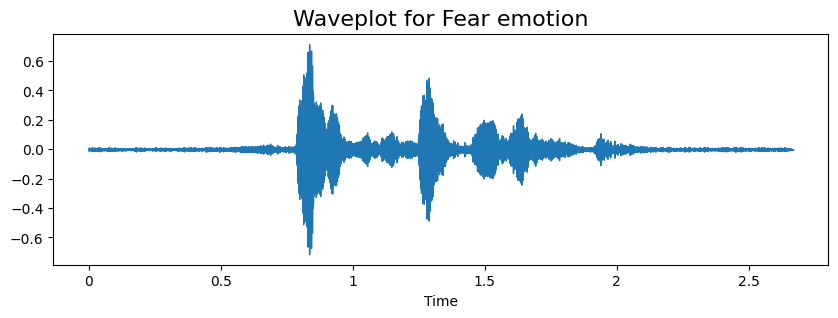

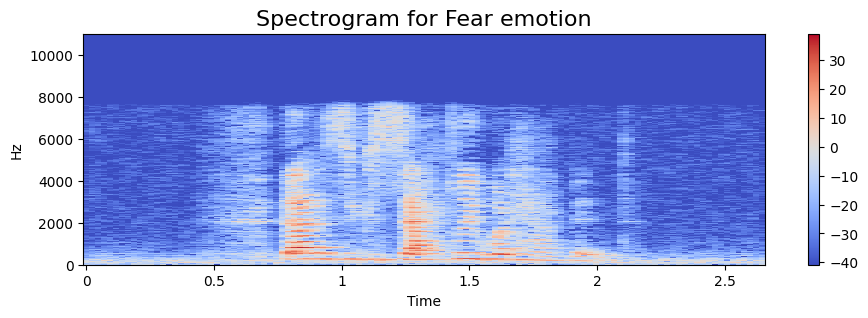

In [ ]:
emotion='FEA'
word_to_display = "Fear"
path = np.array(df.Filepath[df.Label==emotion])[0]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, word_to_display)
create_spectrogram(data, sampling_rate, word_to_display)
Audio(path)

# HAPPY

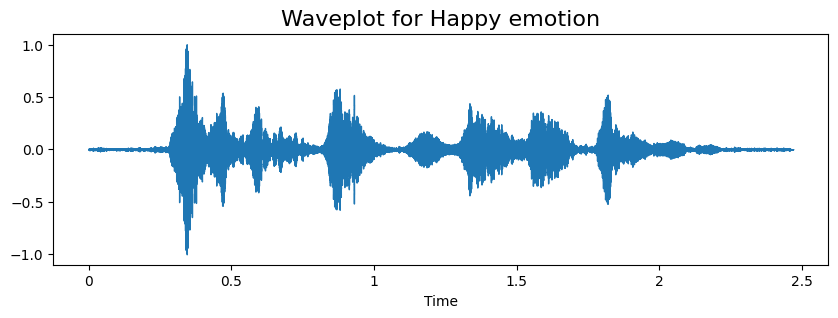

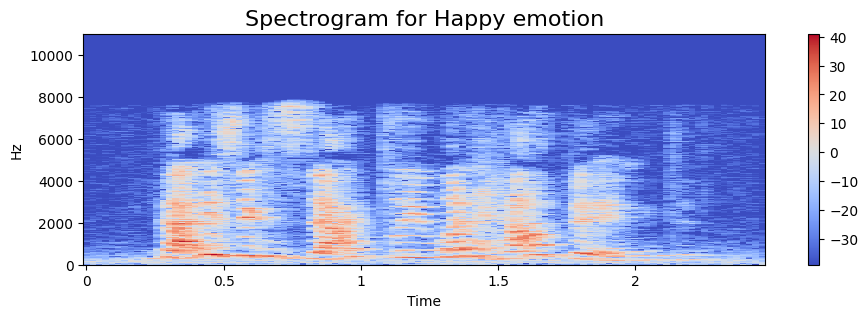

In [ ]:
emotion='HAP'
word_to_display = "Happy"
path = np.array(df.Filepath[df.Label==emotion])[0]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, word_to_display)
create_spectrogram(data, sampling_rate, word_to_display)
Audio(path)

# NEUTRAL

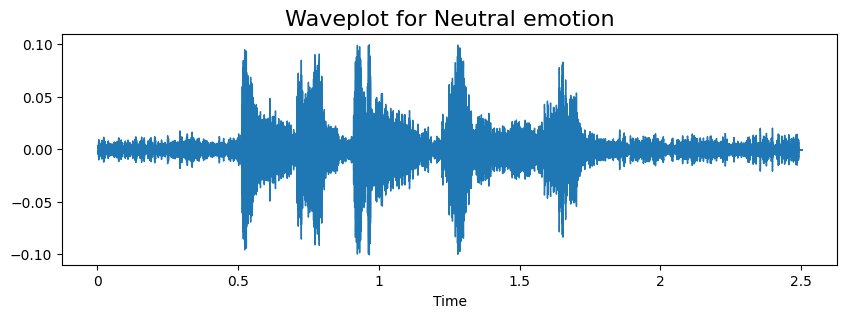

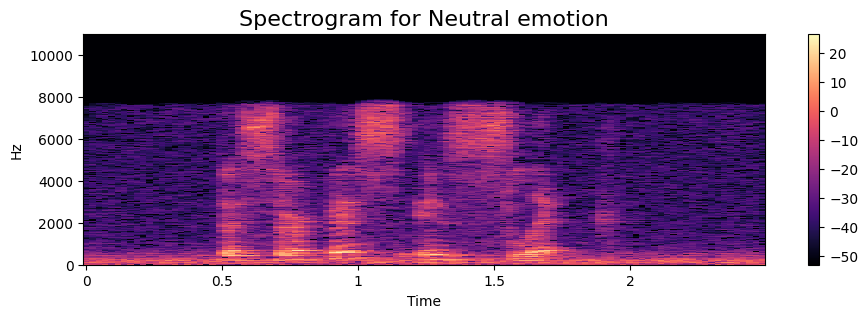

In [ ]:
emotion='NEU'
word_to_display = "Neutral"
path = np.array(df.Filepath[df.Label==emotion])[0]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, word_to_display)
create_spectrogram(data, sampling_rate, word_to_display)
Audio(path)

# Data Augmentation

In [ ]:
# Define the data augmentation functions
def add_noise(data):
    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    return data + noise_amp * np.random.normal(size=data.shape[0])

def time_stretch(data, rate=0.8):
    return librosa.effects.time_stretch(y=data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high=5) * 1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)

def change_volume(data, gain=0.8):
    return data * gain

In [ ]:
# Function to apply all augmentations to a single file
def augment_data(row):
    path = row['Filepath']
    label = row['Label']
    data, sampling_rate = librosa.load(path)

    augmented_samples = [
        (data, label),
        (add_noise(data), label),
        (time_stretch(data, rate=np.random.uniform(0.8, 1.2)), label),
        (shift(data), label),
        (pitch(data, sampling_rate, pitch_factor=np.random.uniform(-2, 2)), label),
        (change_volume(data, gain=0.5), label)
    ]
    return augmented_samples


n_jobs = 7  # Use 7 cores for parallel processing

# Apply augmentations and collect results in a flat list
augmented_data = Parallel(n_jobs=n_jobs)(
    delayed(augment_data)(row) for index, row in tqdm(df.iterrows(), total=len(df))
)

# Flatten the list of augmented samples
augmented_data = [item for sublist in augmented_data for item in sublist]

# Convert augmented data into a DataFrame
augmented_df = pd.DataFrame(augmented_data, columns=['Data', 'Label'])

# Convert original data into a DataFrame
original_data = [(librosa.load(row['Filepath'])[0], row['Label']) for index, row in df.iterrows()]
original_df = pd.DataFrame(original_data, columns=['Data', 'Label'])

# Concatenate original and augmented DataFrames
final_df = pd.concat([original_df, augmented_df], ignore_index=True)

# Print the shape of the final dataset
print(f'Original dataset size: {original_df.shape}')
print(f'Augmented dataset size: {augmented_df.shape}')
print(f'Final dataset size: {final_df.shape}')


  0%|          | 0/7442 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Original dataset size: (7442, 2)
Augmented dataset size: (44652, 2)
Final dataset size: (52094, 2)


# DATA VISUALIZATION FOR AUGMENTED VOICE

# Noise Injection Audio

<Figure size 1400x400 with 0 Axes>

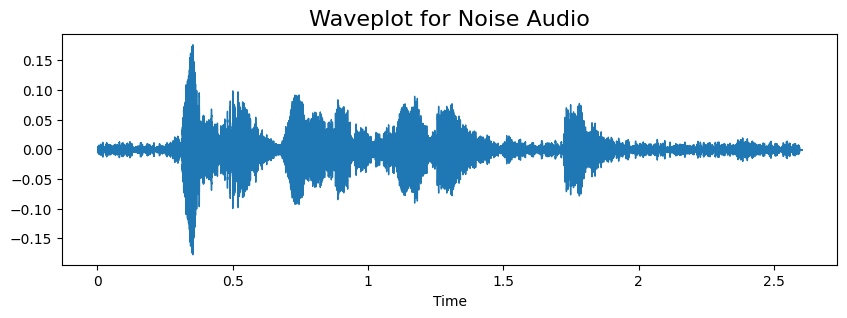

In [ ]:
path = df['Filepath'][1]
word_to_display = 'Noise'
data,sample_rate = librosa.load(path)
x=add_noise(data)
plt.figure(figsize=(14,4))
create_waveplot_aug(data, sampling_rate, word_to_display)
Audio(x,rate=sample_rate)

# Time Stretch Audio

<Figure size 1400x400 with 0 Axes>

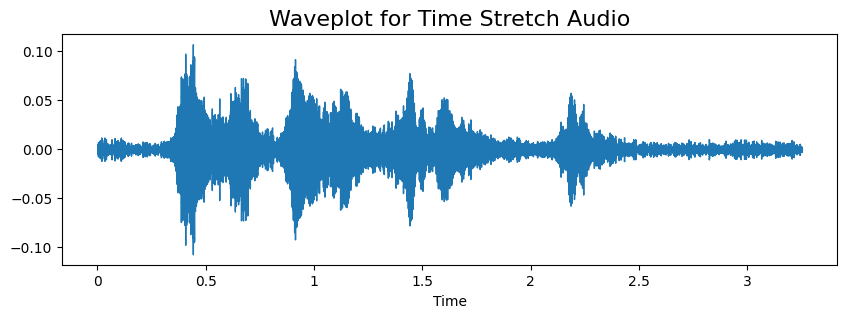

In [ ]:
path = df['Filepath'][1]
word_to_display = 'Time Stretch'
data,sample_rate = librosa.load(path)
x=time_stretch(data)
plt.figure(figsize=(14,4))
create_waveplot_aug(x, sampling_rate, word_to_display)
Audio(x,rate=sample_rate)

# Time Shift Audio

<Figure size 1400x400 with 0 Axes>

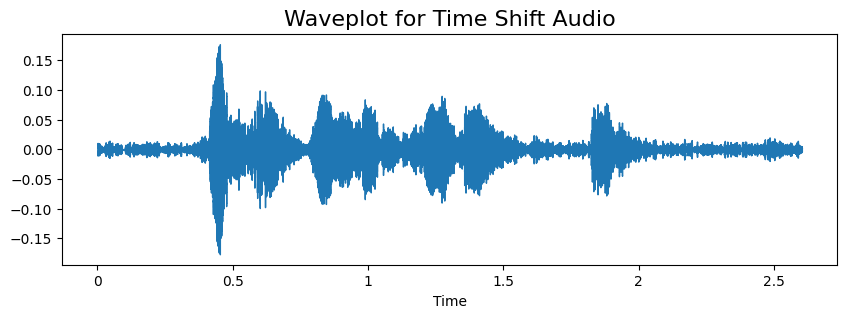

In [ ]:
path = df['Filepath'][1]
word_to_display = 'Time Shift'
data,sample_rate = librosa.load(path)
x=shift(data)
plt.figure(figsize=(14,4))
create_waveplot_aug(x, sampling_rate, word_to_display)
Audio(x,rate=sample_rate)

# Pitch Audio

<Figure size 1400x400 with 0 Axes>

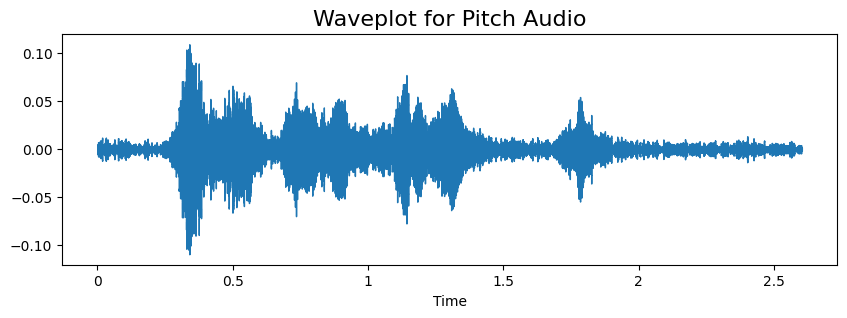

In [ ]:
path = df['Filepath'][1]
word_to_display = 'Pitch'
data,sample_rate = librosa.load(path)
x=pitch(data,sample_rate)
plt.figure(figsize=(14,4))
create_waveplot_aug(x, sampling_rate, word_to_display)
Audio(x,rate=sample_rate)

# Change Volume Audio

<Figure size 1400x400 with 0 Axes>

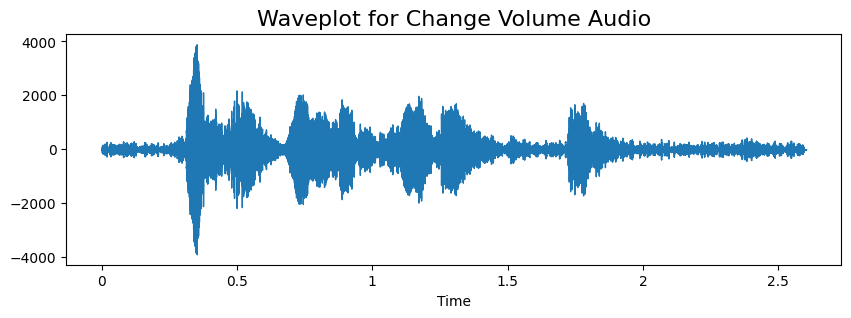

In [ ]:
path = df['Filepath'][1]
word_to_display = "Change Volume"
data,sample_rate = librosa.load(path)
x=change_volume(data,sample_rate)
plt.figure(figsize=(14,4))
create_waveplot_aug(x, sampling_rate, word_to_display)
Audio(x,rate=sample_rate)

In [ ]:
final_df

,Data,Label
0,"[0.0022644894, 0.002788736, 0.003287063, 0.003...",0
1,"[0.0013967396, 0.0010845086, 0.0005326563, 0.0...",0
2,"[-0.0028947387, -0.0036604013, -0.003474595, -...",1
3,"[-0.0030776488, -0.0030352154, -0.0035753506, ...",2
4,"[-0.008033102, -0.008338932, -0.006411011, -0....",1
...,...,...
52089,"[0.009761686456873144, 0.0119448717838641, 0.0...",0
52090,"[0.009936789, 0.011936653, 0.01046477, 0.01124...",0
52091,"[0.0008041641, 0.0014396843, 0.002039243, 0.00...",0
52092,"[0.009459754, 0.011963603, 0.0103133395, 0.011...",0


In [ ]:
label_to_int = {label: idx for idx, label in enumerate(final_df['Label'].unique())}
final_df['Label'] = final_df['Label'].map(label_to_int)

# Print out the mapping
print("Label to integer mapping:")
for label, idx in label_to_int.items():
    print(f"Label '{label}' is encoded as {idx}")

Label to integer mapping:
Label '0' is encoded as 0
Label '1' is encoded as 1
Label '2' is encoded as 2
Label '3' is encoded as 3
Label '4' is encoded as 4
Label '5' is encoded as 5


In [ ]:
final_df

,Data,Label
0,"[0.0022644894, 0.002788736, 0.003287063, 0.003...",0
1,"[0.0013967396, 0.0010845086, 0.0005326563, 0.0...",0
2,"[-0.0028947387, -0.0036604013, -0.003474595, -...",1
3,"[-0.0030776488, -0.0030352154, -0.0035753506, ...",2
4,"[-0.008033102, -0.008338932, -0.006411011, -0....",1
...,...,...
52089,"[0.009761686456873144, 0.0119448717838641, 0.0...",0
52090,"[0.009936789, 0.011936653, 0.01046477, 0.01124...",0
52091,"[0.0008041641, 0.0014396843, 0.002039243, 0.00...",0
52092,"[0.009459754, 0.011963603, 0.0103133395, 0.011...",0


# Experiment 2 with MFCC

In [ ]:

# Function to extract MFCC, chroma, and mel spectrogram features from audio data with padding
def extract_features(data, sample_rate, n_mfcc=13, n_chroma=12, n_mels=40, max_len=100):
    # Extract MFCC features
    mfccs = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=n_mfcc)
    if mfccs.shape[1] > max_len:
        mfccs = mfccs[:, :max_len]
    else:
        pad_width = max_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')

    # Extract Chroma features
    chroma = librosa.feature.chroma_stft(y=data, sr=sample_rate, n_chroma=n_chroma)
    if chroma.shape[1] > max_len:
        chroma = chroma[:, :max_len]
    else:
        pad_width = max_len - chroma.shape[1]
        chroma = np.pad(chroma, pad_width=((0, 0), (0, pad_width)), mode='constant')

    # Extract Mel spectrogram features
    mel = librosa.feature.melspectrogram(y=data, sr=sample_rate, n_mels=n_mels)
    if mel.shape[1] > max_len:
        mel = mel[:, :max_len]
    else:
        pad_width = max_len - mel.shape[1]
        mel = np.pad(mel, pad_width=((0, 0), (0, pad_width)), mode='constant')

    # Concatenate all features along the first axis (feature axis)
    features = np.concatenate((mfccs, chroma, mel), axis=0)
    return features.T

# Initialize two empty arrays to store the extracted features and labels
features = []
labels = []

# Iterate over each row in the DataFrame and call the function
for index, row in tqdm(final_df.iterrows()):
    data = row['Data']
    label = row['Label']
    sample_rate = 22050
    feature = extract_features(data, sample_rate)
    features.append(feature)
    labels.append(label)

# Convert lists to numpy arrays to be more suitable for Machine Learning libraries
features = np.array(features)
labels = np.array(labels)

# Check the shape of features
print(f'Features shape before reshaping: {features.shape}')
print(f'Labels shape: {labels.shape}')

# Reshape to 3D for CNN input (number of samples, number of timesteps, number of features)
nsamples, nx, ny = features.shape
features = features.reshape((nsamples, nx, ny))

# Check the shape after reshaping
print(f'Features shape after reshaping: {features.shape}')

0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Features shape before reshaping: (52094, 100, 65)
Labels shape: (52094,)
Features shape after reshaping: (52094, 100, 65)


In [ ]:
labels.shape

(52094,)

In [ ]:
# Split data into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)
# Convert labels to categorical (one-hot encoding) so that suitable for neural network training
num_classes = len(np.unique(y_train))
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
y_val = to_categorical(y_val, num_classes)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_val shape: {y_val.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train.shape, X_test.shape, y_train.shape, y_test.shape , X_val.shape, y_val.shape

X_train shape: (35423, 100, 65)
y_train shape: (35423, 6)
X_val shape: (6252, 100, 65)
y_val shape: (6252, 6)
X_test shape: (10419, 100, 65)
y_test shape: (10419, 6)
y_test shape: (10419, 6)


((35423, 100, 65),
 (10419, 100, 65),
 (35423, 6),
 (10419, 6),
 (6252, 100, 65),
 (6252, 6))

In [ ]:
!rm -rf "/content/my_dir"


In [ ]:


model = Sequential()
model.add(Conv1D(64, 3, activation='relu', input_shape=(100, 65)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(256, 3, activation='relu' ),)
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(512, 3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(1024, 3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(512, activation='relu' ))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax' ))

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

# Print the model summary
model.summary()

# Implement early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the model
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=128,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_52 (Conv1D)                   │ (None, 98, 64)              │          12,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_52 (MaxPooling1D)      │ (None, 49, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_53 (Conv1D)                   │ (None, 47, 256)             │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_53 (MaxPooling1D)      │ (None, 23, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_54 (Conv1D)                   │ (None, 21, 512)             │         393,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_54 (MaxPooling1D)      │ (None, 10, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_55 (Conv1D)                   │ (None, 8, 1024)             │       1,573,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_55 (MaxPooling1D)      │ (None, 4, 1024)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_15 (Flatten)                 │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_73 (Dense)                     │ (None, 512)                 │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_78 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_74 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_79 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_75 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_80 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_76 (Dense)                     │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,292,230 (16.37 MB)

 Trainable params: 4,292,230 (16.37 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step - accuracy: 0.2283 - loss: 3.3382 - val_accuracy: 0.3626 - val_loss: 1.5315
Epoch 2/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3719 - loss: 1.5104 - val_accuracy: 0.4677 - val_loss: 1.3578
Epoch 3/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4342 - loss: 1.4114 - val_accuracy: 0.4899 - val_loss: 1.3021
Epoch 4/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4918 - loss: 1.3020 - val_accuracy: 0.5505 - val_loss: 1.1869
Epoch 5/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5510 - loss: 1.1788 - val_accuracy: 0.5888 - val_loss: 1.0720
Epoch 6/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6097 - loss: 1.0462 - val_accuracy: 0.6374 - val_loss: 0.9636
Epoch 7/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6571 - loss: 0.9277 - val_accuracy: 0.6846 - val_loss: 0.8434
Epoch 8/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7088 - loss: 0.8020 - val_accuracy: 

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Make predictions on the test set
predictions = model.predict(X_test)



326/326 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.8834 - loss: 0.4245
Test Loss: 0.4183371067047119
Test Accuracy: 0.8844419121742249
326/326 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


Confusion Matrix


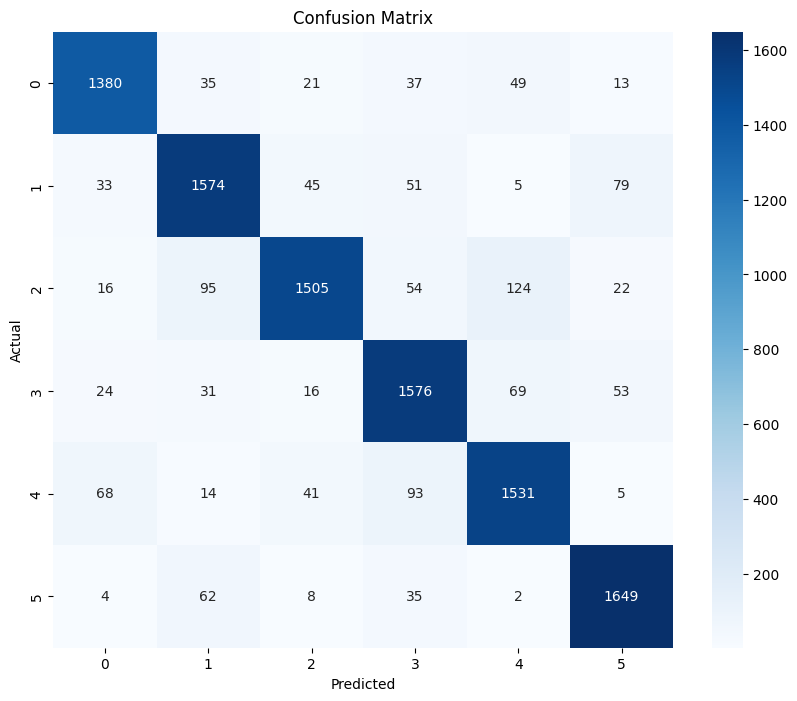

Classification Report
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1535
           1       0.87      0.88      0.87      1787
           2       0.92      0.83      0.87      1816
           3       0.85      0.89      0.87      1769
           4       0.86      0.87      0.87      1752
           5       0.91      0.94      0.92      1760

    accuracy                           0.88     10419
   macro avg       0.89      0.89      0.88     10419
weighted avg       0.89      0.88      0.88     10419



In [ ]:
# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
print('Confusion Matrix')
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# Classification Report
cr = classification_report(true_classes, predicted_classes)
print('Classification Report')
print(cr)

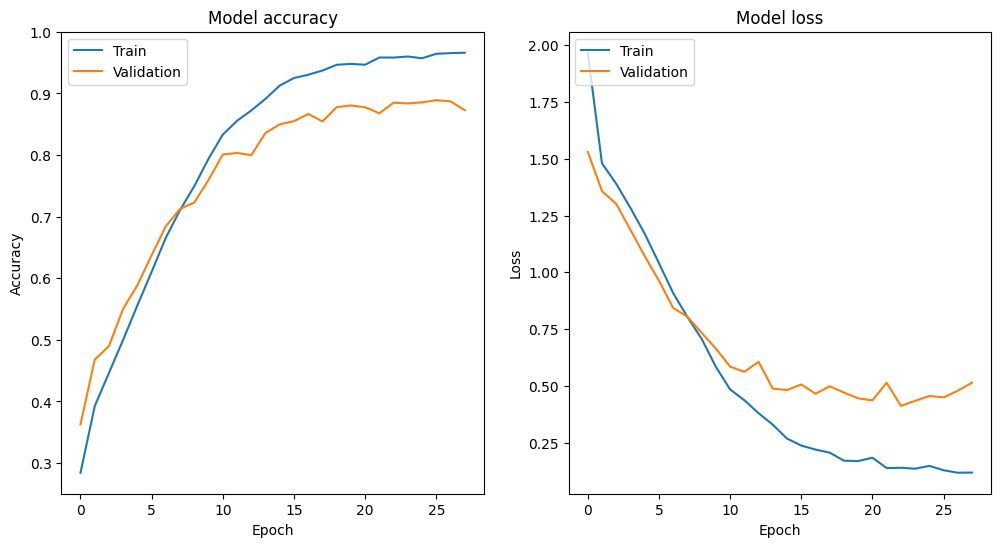

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Experiment 2 without MFCC

In [ ]:

# Function to extract chroma, and mel spectrogram features from audio data with padding
def extract_features(data, sample_rate, n_chroma=12, n_mels=40, max_len=100):

    # Extract Chroma features
    chroma = librosa.feature.chroma_stft(y=data, sr=sample_rate, n_chroma=n_chroma)
    if chroma.shape[1] > max_len:
        chroma = chroma[:, :max_len]
    else:
        pad_width = max_len - chroma.shape[1]
        chroma = np.pad(chroma, pad_width=((0, 0), (0, pad_width)), mode='constant')

    # Extract Mel spectrogram features
    mel = librosa.feature.melspectrogram(y=data, sr=sample_rate, n_mels=n_mels)
    if mel.shape[1] > max_len:
        mel = mel[:, :max_len]
    else:
        pad_width = max_len - mel.shape[1]
        mel = np.pad(mel, pad_width=((0, 0), (0, pad_width)), mode='constant')

    # Concatenate all features along the first axis (feature axis)
    features = np.concatenate((chroma, mel), axis=0)
    return features.T

# Initialize two empty arrays to store the extracted features and labels
features = []
labels = []

# Iterate over each row in the DataFrame and call the function
for index, row in tqdm(final_df.iterrows()):
    data = row['Data']
    label = row['Label']
    sample_rate = 22050
    feature = extract_features(data, sample_rate)
    features.append(feature)
    labels.append(label)

# Convert lists to numpy arrays to be more suitable for Machine Learning libraries
features = np.array(features)
labels = np.array(labels)

# Check the shape of features
print(f'Features shape before reshaping: {features.shape}')
print(f'Labels shape: {labels.shape}')

# Reshape to 3D for CNN input (number of samples, number of timesteps, number of features)
nsamples, nx, ny = features.shape
features = features.reshape((nsamples, nx, ny))

# Check the shape after reshaping
print(f'Features shape after reshaping: {features.shape}')

0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Features shape before reshaping: (52094, 100, 52)
Labels shape: (52094,)
Features shape after reshaping: (52094, 100, 52)


In [ ]:
labels.shape

(52094,)

In [ ]:
# Split data into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)
# Convert labels to categorical (one-hot encoding) so that suitable for neural network training
num_classes = len(np.unique(y_train))
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
y_val = to_categorical(y_val, num_classes)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_val shape: {y_val.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train.shape, X_test.shape, y_train.shape, y_test.shape , X_val.shape, y_val.shape

X_train shape: (35423, 100, 52)
y_train shape: (35423, 6)
X_val shape: (6252, 100, 52)
y_val shape: (6252, 6)
X_test shape: (10419, 100, 52)
y_test shape: (10419, 6)
y_test shape: (10419, 6)


((35423, 100, 52),
 (10419, 100, 52),
 (35423, 6),
 (10419, 6),
 (6252, 100, 52),
 (6252, 6))

In [ ]:
model = Sequential()
model.add(Conv1D(64, 3, activation='relu', input_shape=(100, 52)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(256, 3, activation='relu' ),)
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(512, 3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(1024, 3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(512, activation='relu' ))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax' ))

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

# Print the model summary
model.summary()

# Implement early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the model
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=128,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 98, 64)              │          10,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 49, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 47, 256)             │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 23, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 21, 512)             │         393,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 10, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 8, 1024)             │       1,573,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 4, 1024)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,289,734 (16.36 MB)

 Trainable params: 4,289,734 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 23s 53ms/step - accuracy: 0.2702 - loss: 2.1199 - val_accuracy: 0.3951 - val_loss: 1.4965
Epoch 2/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3743 - loss: 1.5111 - val_accuracy: 0.3807 - val_loss: 1.4826
Epoch 3/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4272 - loss: 1.4192 - val_accuracy: 0.4877 - val_loss: 1.3083
Epoch 4/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4771 - loss: 1.3252 - val_accuracy: 0.5235 - val_loss: 1.2169
Epoch 5/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5289 - loss: 1.2172 - val_accuracy: 0.5653 - val_loss: 1.1241
Epoch 6/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5825 - loss: 1.1105 - val_accuracy: 0.6048 - val_loss: 1.0247
Epoch 7/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6427 - loss: 0.9654 - val_accuracy: 0.6017 - val_loss: 1.0321
Epoch 8/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6829 - loss: 0.8678 - val_accuracy: 

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Make predictions on the test set
predictions = model.predict(X_test)

# Print the predictions
print(predictions)

326/326 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7804 - loss: 0.6948
Test Loss: 0.6760225892066956
Test Accuracy: 0.7823207378387451
326/326 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
[[9.7393584e-01 3.3129465e-03 5.2162929e-04 5.0305715e-03 1.7128043e-02
  7.0801965e-05]
 [4.0975051e-33 1.5504163e-06 1.8693473e-12 1.1168778e-11 2.4347424e-31
  9.9999845e-01]
 [5.8707077e-04 8.2800877e-01 4.6135182e-03 6.6891094e-03 5.6142658e-06
  1.6009590e-01]
 ...
 [5.8020774e-04 1.7156814e-03 2.2469275e-02 9.1943616e-01 5.3760506e-02
  2.0381459e-03]
 [2.5518179e-05 1.3905043e-03 1.1859171e-03 9.8332906e-01 5.1106693e-04
  1.3557903e-02]
 [3.6349125e-02 9.2972636e-01 2.3036370e-02 3.7162460e-03 4.8620190e-04
  6.6856807e-03]]


Confusion Matrix


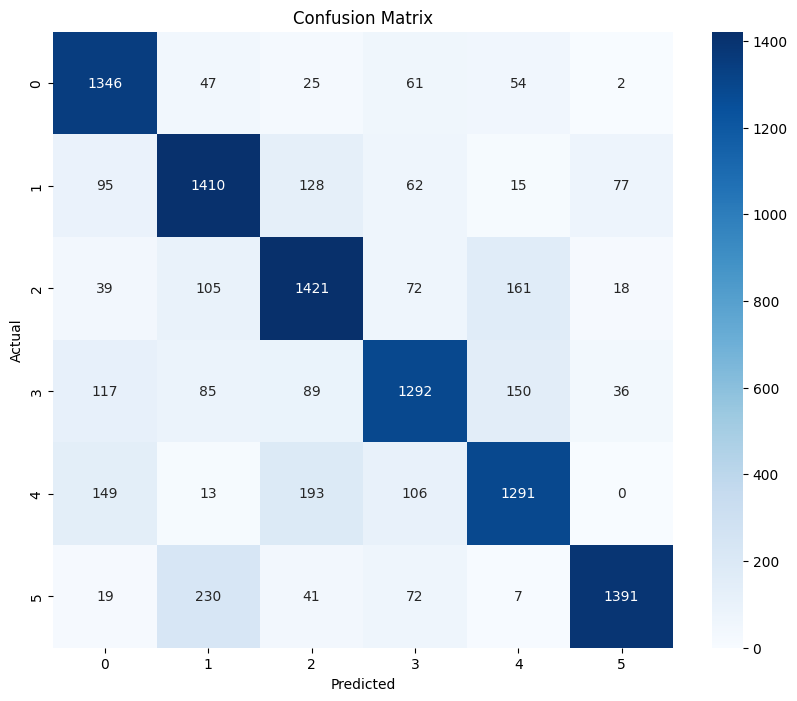

Classification Report
              precision    recall  f1-score   support

           0       0.76      0.88      0.82      1535
           1       0.75      0.79      0.77      1787
           2       0.75      0.78      0.77      1816
           3       0.78      0.73      0.75      1769
           4       0.77      0.74      0.75      1752
           5       0.91      0.79      0.85      1760

    accuracy                           0.78     10419
   macro avg       0.79      0.78      0.78     10419
weighted avg       0.79      0.78      0.78     10419



In [ ]:
# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
print('Confusion Matrix')
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# Classification Report
cr = classification_report(true_classes, predicted_classes)
print('Classification Report')
print(cr)

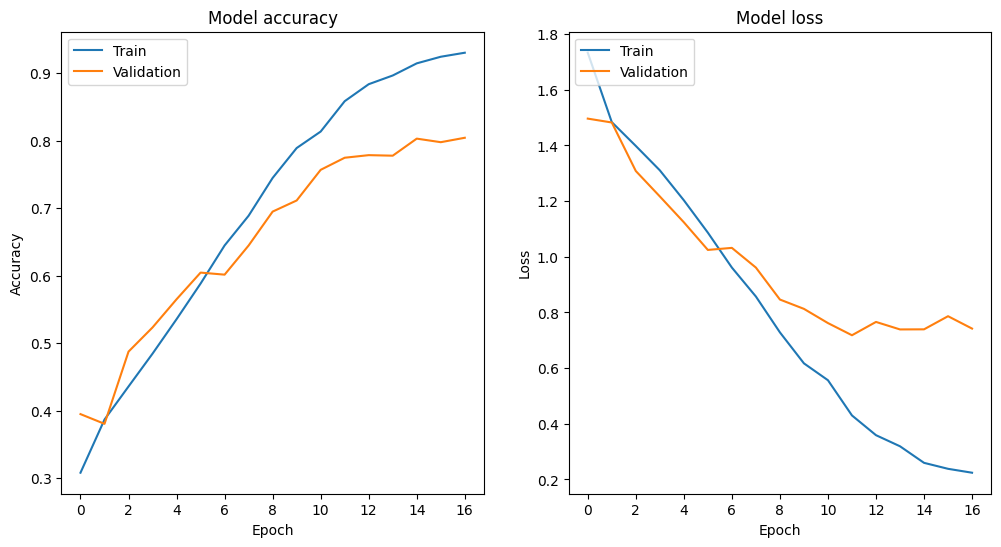

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# In conclusion , After experiment found out that feature extraction with MFCC has higher accuracy.

# Hyperparameter Tuning CNN

In [ ]:
!pip install keras-tuner
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
import numpy as np

def build_model(hp):
    model = Sequential()

    # Define the first Conv1D layer with tunable filters and kernel size
    model.add(Conv1D(
        filters=hp.Int('filters_1', min_value=128, max_value=1024, step=32),
        kernel_size=hp.Choice('kernel_size_1', values=[3, 5, 7]),
        activation='relu',
        # kernel_regularizer=regularizers.l2(0.01),
        input_shape=(100, 65)
    ))
    model.add(MaxPooling1D(pool_size=2))

    # Add additional Conv1D layers based on tunable number of layers
    for i in range(hp.Int('num_conv_layers', 1, 3)):
        model.add(Conv1D(
            filters=hp.Int(f'filters_{i+2}', min_value=128, max_value=1024, step=32),
            kernel_size=hp.Choice(f'kernel_size_{i+2}', values=[3, 5, 7]),
            activation='relu',
            # kernel_regularizer=regularizers.l2(0.01)
        ))
        model.add(MaxPooling1D(pool_size=2))

    # Add Flatten layer
    model.add(Flatten())

    # Add Dense layer with tunable units
    model.add(Dense(units=hp.Int('units', min_value=128, max_value=1024, step=64), activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))

    # Output layer
    model.add(Dense(6, activation='softmax'))

    # Compile the model with tunable learning rate
    model.compile(
        optimizer=RMSprop(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Number of hyperparameter combinations to try
    executions_per_trial=2,  # Number of models to train per trial to reduce variance
    directory='my_dir',
    project_name='speech_emotion_recognition'
)



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Start the hyperparameter search
tuner.search(X_train, y_train,
             epochs=30,
             validation_data=(X_val, y_val),
             callbacks=[early_stopping])




Trial 10 Complete [00h 01m 16s]
val_accuracy: 0.5185540616512299

Best val_accuracy So Far: 0.7303262948989868
Total elapsed time: 00h 19m 54s


In [ ]:
# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print(f'''
The hyperparameter search is complete. Here are the best hyperparameters:
- Filters in the first Conv1D layer: {best_hps.get('filters_1')}
- Kernel size in the first Conv1D layer: {best_hps.get('kernel_size_1')}
- Number of Conv1D layers: {best_hps.get('num_conv_layers')}
- Filters in the second Conv1D layer: {best_hps.get('filters_2')}
- Kernel size in the second Conv1D layer: {best_hps.get('kernel_size_2')}
- Units in the Dense layer: {best_hps.get('units')}
- Dropout rate: {best_hps.get('dropout')}
- Learning rate: {best_hps.get('learning_rate')}
''')

# Build the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)

# Print a summary of the model
model.summary()



The hyperparameter search is complete. Here are the best hyperparameters:
- Filters in the first Conv1D layer: 160
- Kernel size in the first Conv1D layer: 7
- Number of Conv1D layers: 2
- Filters in the second Conv1D layer: 960
- Kernel size in the second Conv1D layer: 7
- Units in the Dense layer: 640
- Dropout rate: 0.30000000000000004
- Learning rate: 0.0003781383962816197



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)                    │ (None, 94, 160)             │          72,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 47, 160)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 41, 960)             │       1,076,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 20, 960)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 16, 608)             │       2,919,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 8, 608)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 4864)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 640)                 │       3,113,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 640)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │           3,846 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,185,574 (27.41 MB)

 Trainable params: 7,185,574 (27.41 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - accuracy: 0.2796 - loss: 16.4780 - val_accuracy: 0.3367 - val_loss: 1.8282
Epoch 2/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4886 - loss: 1.3209 - val_accuracy: 0.5689 - val_loss: 1.0929
Epoch 3/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6136 - loss: 1.0116 - val_accuracy: 0.6843 - val_loss: 0.8683
Epoch 4/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7472 - loss: 0.6952 - val_accuracy: 0.7806 - val_loss: 0.6187
Epoch 5/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8472 - loss: 0.4355 - val_accuracy: 0.8089 - val_loss: 0.5834
Epoch 6/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8995 - loss: 0.2863 - val_accuracy: 0.8591 - val_loss: 0.4851
Epoch 7/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9374 - loss: 0.1910 - val_accuracy: 0.8784 - val_loss: 0.4006
Epoch 8/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9524 - loss: 0.1462 - val_accuracy:

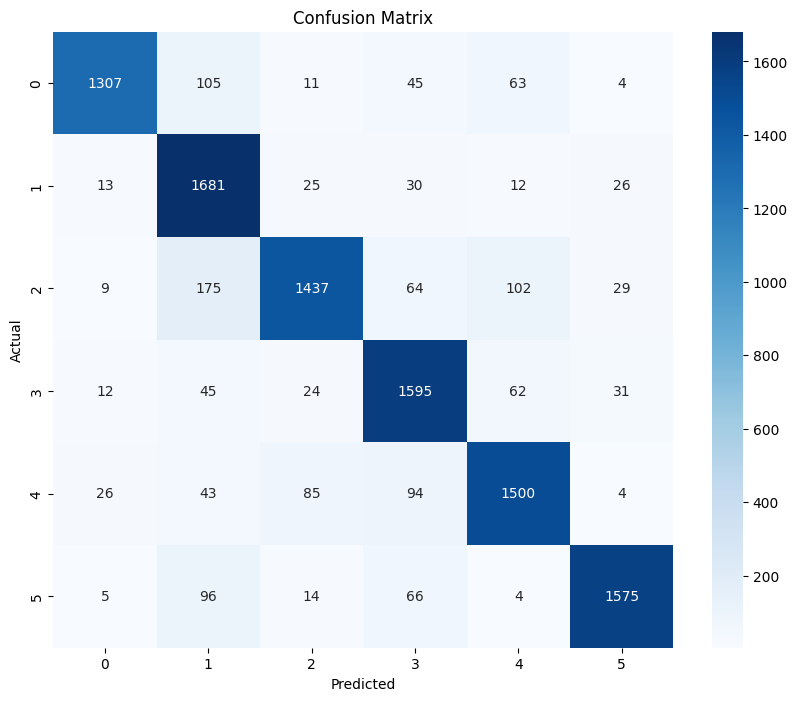

In [ ]:
# Train the model with the best hyperparameters
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=128,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Generate predictions and evaluate further
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

report = classification_report(y_true_classes, y_pred_classes)
print(report)

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


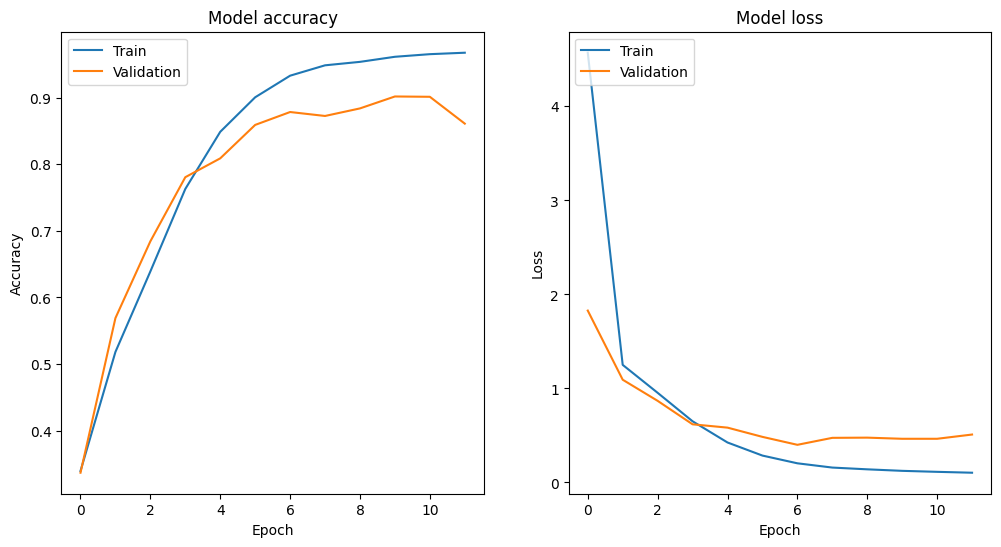

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
# Save the trained model to a file
model.save('/content/drive/MyDrive/FYP/Speech_emotion_recognition/code /50K_best_cnn_model.h5')

# from tensorflow.keras.models import load_model

# # Load the saved model
# model = load_model('best_cnn_model.h5')


# LSTM

In [ ]:
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential, load_model

# Define the LSTM model
model = Sequential()

# Add an LSTM layer with 128 units
model.add(LSTM(128, return_sequences=True, input_shape=(100, 65),))
model.add(Dropout(0.3))

# Add another LSTM layer with 256 units
model.add(LSTM(256 ,return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(512))
model.add(Dropout(0.3))

# Add a Dense layer with 128 units
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

# Add a Dense layer with 128 units
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))

# Output layer with softmax activation
model.add(Dense(6, activation='softmax'))

# Compile the model
model.compile(
    optimizer=RMSprop(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print the model summary
model.summary()

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=128,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 100, 128)            │          99,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 100, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 100, 256)            │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 100, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 512)                 │       1,574,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,233,478 (8.52 MB)

 Trainable params: 2,233,478 (8.52 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.3279 - loss: 1.6259 - val_accuracy: 0.4407 - val_loss: 1.4231
Epoch 2/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.4317 - loss: 1.4128 - val_accuracy: 0.4779 - val_loss: 1.3245
Epoch 3/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.4793 - loss: 1.3313 - val_accuracy: 0.5030 - val_loss: 1.2568
Epoch 4/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.5047 - loss: 1.2678 - val_accuracy: 0.5339 - val_loss: 1.1976
Epoch 5/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.5232 - loss: 1.2239 - val_accuracy: 0.5425 - val_loss: 1.1635
Epoch 6/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.5477 - loss: 1.1687 - val_accuracy: 0.5629 - val_loss: 1.1365
Epoch 7/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.5687 - loss: 1.1210 - val_accuracy: 0.5785 - val_loss: 1.0847
Epoch 8/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.5879 - loss: 1.0835 - val_acc

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Make predictions on the test set
predictions = model.predict(X_test)

# Print the predictions
print(predictions)

326/326 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8630 - loss: 0.4667
Test Loss: 0.46098655462265015
Test Accuracy: 0.8635185956954956
326/326 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
[[9.9878353e-01 2.1622011e-05 1.1360354e-05 6.7471946e-04 5.0550251e-04
  3.2678274e-06]
 [2.2130934e-08 7.6792394e-06 6.1407001e-05 7.2196694e-06 1.5153171e-07
  9.9992359e-01]
 [2.7528146e-04 9.9088013e-01 1.3253946e-03 7.5031854e-03 1.1777426e-05
  4.3078949e-06]
 ...
 [2.7911158e-04 4.1257748e-03 3.7645584e-03 9.8727846e-01 2.2526898e-03
  2.2994273e-03]
 [3.5028940e-03 2.7224377e-02 5.0955438e-03 9.5654863e-01 6.7263609e-03
  9.0225105e-04]
 [1.5584044e-03 6.9336271e-01 2.9213065e-01 1.0898789e-02 9.4374456e-04
  1.1056581e-03]]


Confusion Matrix


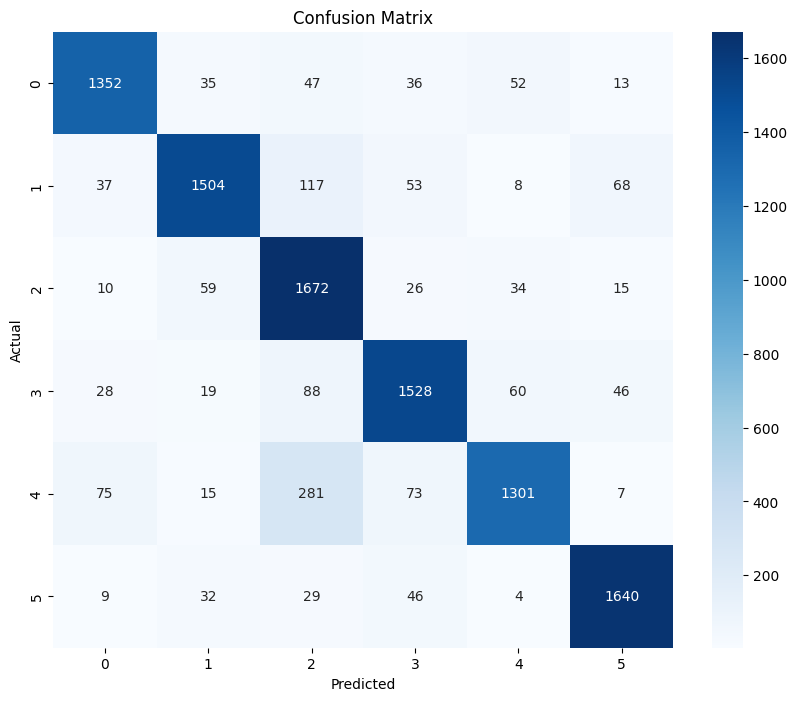

Classification Report
              precision    recall  f1-score   support

           0       0.89      0.88      0.89      1535
           1       0.90      0.84      0.87      1787
           2       0.75      0.92      0.83      1816
           3       0.87      0.86      0.87      1769
           4       0.89      0.74      0.81      1752
           5       0.92      0.93      0.92      1760

    accuracy                           0.86     10419
   macro avg       0.87      0.86      0.86     10419
weighted avg       0.87      0.86      0.86     10419



In [ ]:
# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
print('Confusion Matrix')
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# Classification Report
cr = classification_report(true_classes, predicted_classes)
print('Classification Report')
print(cr)

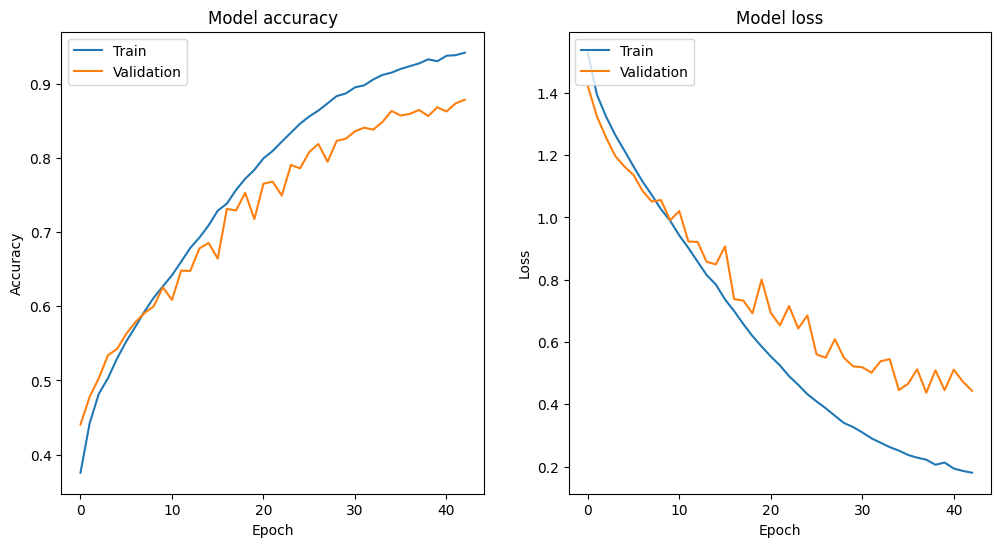

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# LSTM(Tuning)

In [ ]:
from tensorflow.keras.layers import LSTM

# Define a function to build the model
def build_model(hp):
    model = Sequential()

    # LSTM layer with variable units
    model.add(LSTM(units=hp.Int('units_lstm_1', min_value=32, max_value=512, step=32),
                   return_sequences=True, input_shape=(100, 65)))
    model.add(Dropout(hp.Float('dropout_lstm_1', min_value=0.1, max_value=0.5, step=0.1)))

    # Another LSTM layer with variable units
    model.add(LSTM(units=hp.Int('units_lstm_2', min_value=32, max_value=512, step=32)))
    model.add(Dropout(hp.Float('dropout_lstm_2', min_value=0.1, max_value=0.5, step=0.1)))

    # Dense layer with variable units
    model.add(Dense(units=hp.Int('units_dense', min_value=32, max_value=512, step=32), activation='relu'))
    model.add(Dropout(hp.Float('dropout_dense', min_value=0.1, max_value=0.5, step=0.1)))

    # Output layer
    model.add(Dense(6, activation='softmax'))

    # Compile the model
    model.compile(
        optimizer=RMSprop(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [ ]:
# Initialize the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Number of different hyperparameter combinations to try
    executions_per_trial=2,  # execution to run in a trial
    directory='my_dir',
    project_name='lstm_tuning'
)



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Perform the search
tuner.search(
    X_train, y_train,
    epochs=10,
    batch_size=128,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

Trial 10 Complete [00h 02m 00s]
val_accuracy: 0.6899392306804657

Best val_accuracy So Far: 0.6899392306804657
Total elapsed time: 00h 15m 50s


In [ ]:
# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print(f'''
The hyperparameter search is complete. Here are the best hyperparameters:
- Units in the first LSTM layer: {best_hps.get('units_lstm_1')}
- Dropout rate for the first LSTM layer: {best_hps.get('dropout_lstm_1')}
- Units in the second LSTM layer: {best_hps.get('units_lstm_2')}
- Dropout rate for the second LSTM layer: {best_hps.get('dropout_lstm_2')}
- Units in the Dense layer: {best_hps.get('units_dense')}
- Dropout rate for the Dense layer: {best_hps.get('dropout_dense')}
- Learning rate: {best_hps.get('learning_rate')}
''')

# Build the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)

# Print a summary of the model
model.summary()



The hyperparameter search is complete. Here are the best hyperparameters:
- Units in the first LSTM layer: 480
- Dropout rate for the first LSTM layer: 0.1
- Units in the second LSTM layer: 192
- Dropout rate for the second LSTM layer: 0.4
- Units in the Dense layer: 384
- Dropout rate for the Dense layer: 0.5
- Learning rate: 0.0008508593738548981



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 100, 480)            │       1,048,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 100, 480)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 192)                 │         516,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 192)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 384)                 │          74,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │           2,310 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,641,606 (6.26 MB)

 Trainable params: 1,641,606 (6.26 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.3432 - loss: 1.5648 - val_accuracy: 0.4560 - val_loss: 1.3759
Epoch 2/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.4558 - loss: 1.3549 - val_accuracy: 0.5026 - val_loss: 1.2667
Epoch 3/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.5051 - loss: 1.2605 - val_accuracy: 0.5166 - val_loss: 1.2236
Epoch 4/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.5357 - loss: 1.1956 - val_accuracy: 0.5405 - val_loss: 1.1890
Epoch 5/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.5719 - loss: 1.1160 - val_accuracy: 0.5846 - val_loss: 1.0857
Epoch 6/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.6017 - loss: 1.0438 - val_accuracy: 0.5877 - val_loss: 1.0726
Epoch 7/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.6189 - loss: 0.9886 - val_accuracy: 0.5545 - val_loss: 1.1861
Epoch 8/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.6507 - loss: 0.9226 - val_accu

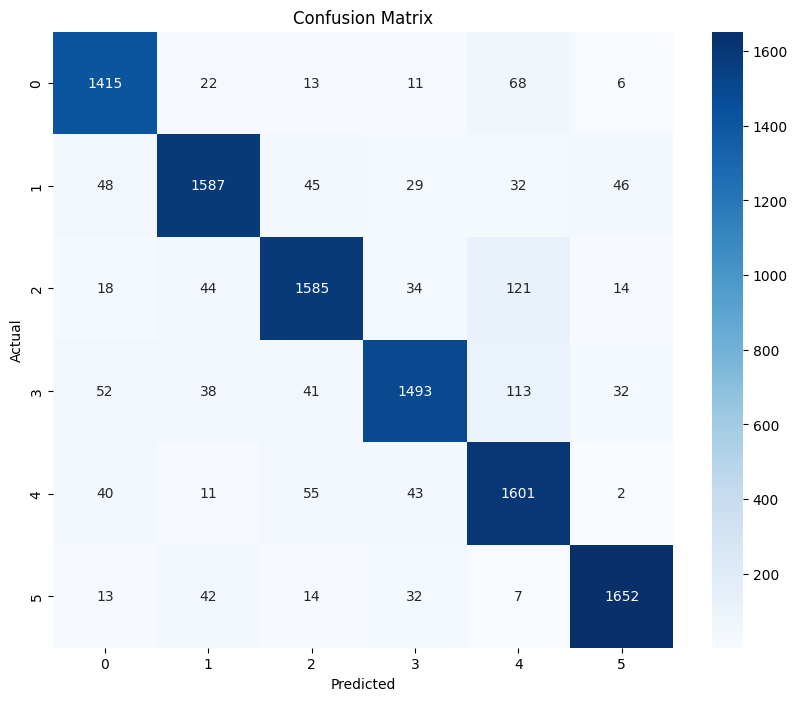

In [ ]:
# Train the model with the best hyperparameters
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=128,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Generate predictions and evaluate further
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

report = classification_report(y_true_classes, y_pred_classes)
print(report)

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


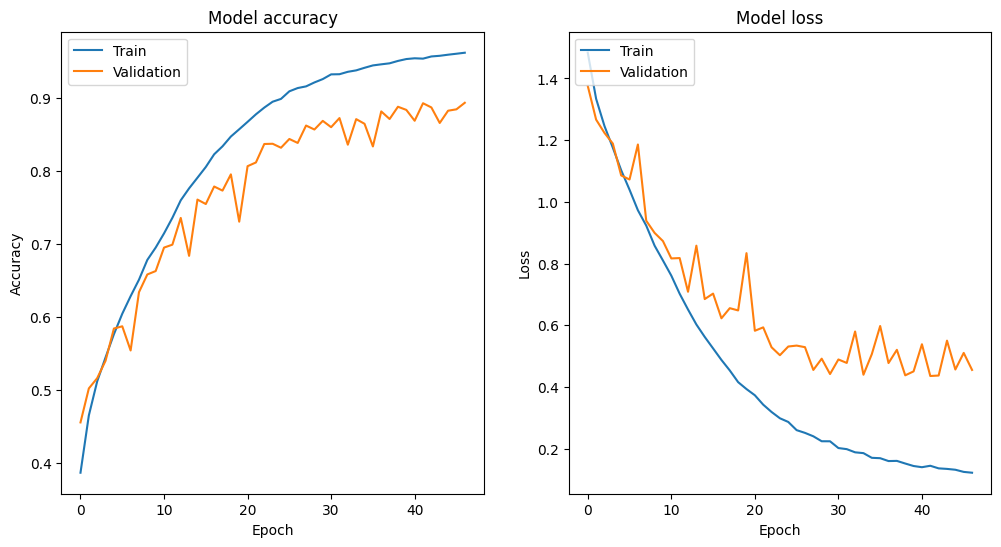

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
# Save the trained model to a file
model.save('/content/drive/MyDrive/FYP/Speech_emotion_recognition/code /50K_best_lstm_model.h5')

# from tensorflow.keras.models import load_model

# # Load the saved model
# model = load_model('best_cnn_model.h5')


# GRU

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 100, 128)            │          74,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 100, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 256)                 │         296,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 404,998 (1.54 MB)

 Trainable params: 404,998 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.3471 - loss: 1.5738 - val_accuracy: 0.4311 - val_loss: 1.4394
Epoch 2/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.4314 - loss: 1.3940 - val_accuracy: 0.4626 - val_loss: 1.3305
Epoch 3/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.4753 - loss: 1.3064 - val_accuracy: 0.5008 - val_loss: 1.2586
Epoch 4/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5209 - loss: 1.2112 - val_accuracy: 0.5392 - val_loss: 1.1707
Epoch 5/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5494 - loss: 1.1591 - val_accuracy: 0.5553 - val_loss: 1.1395
Epoch 6/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5746 - loss: 1.0951 - val_accuracy: 0.5853 - val_loss: 1.0638
Epoch 7/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.6049 - loss: 1.0367 - val_accuracy: 0.6161 - val_loss: 0.9846
Epoch 8/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.6368 - loss: 0.9663 - val_accu

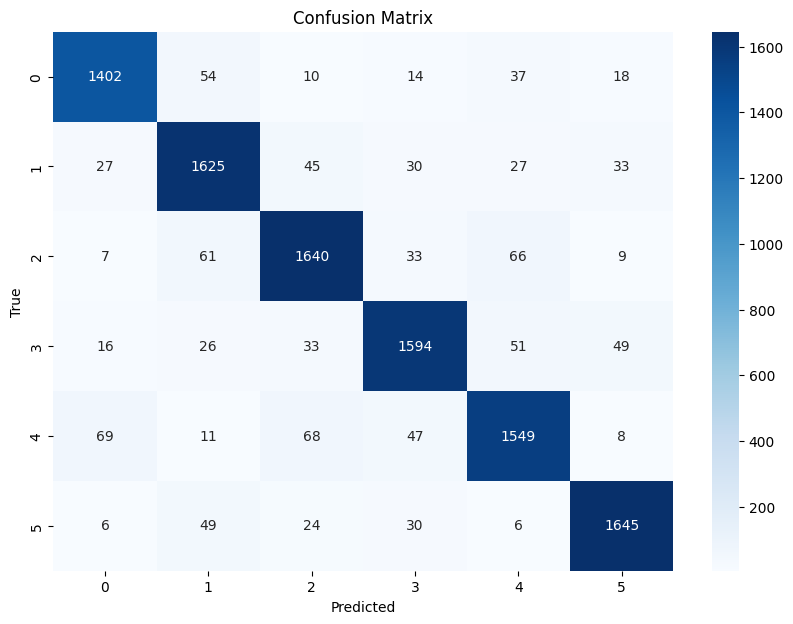

In [ ]:
# Define a function to build the GRU model
def build_gru_model():
    model = Sequential()

    # First GRU layer
    model.add(GRU(units=128, return_sequences=True, input_shape=(100, 65)))
    model.add(Dropout(0.3))

    # Second GRU layer
    model.add(GRU(units=256))
    model.add(Dropout(0.3))

    # Dense layer
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(0.3))

    # Output layer
    model.add(Dense(6, activation='softmax'))

    # Compile the model
    model.compile(
        optimizer=RMSprop(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Build the model
model = build_gru_model()

# Print a summary of the model
model.summary()

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=128,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Generate predictions and evaluate further
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Print classification report
report = classification_report(y_true_classes, y_pred_classes)
print(report)

# Optionally, plot the confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

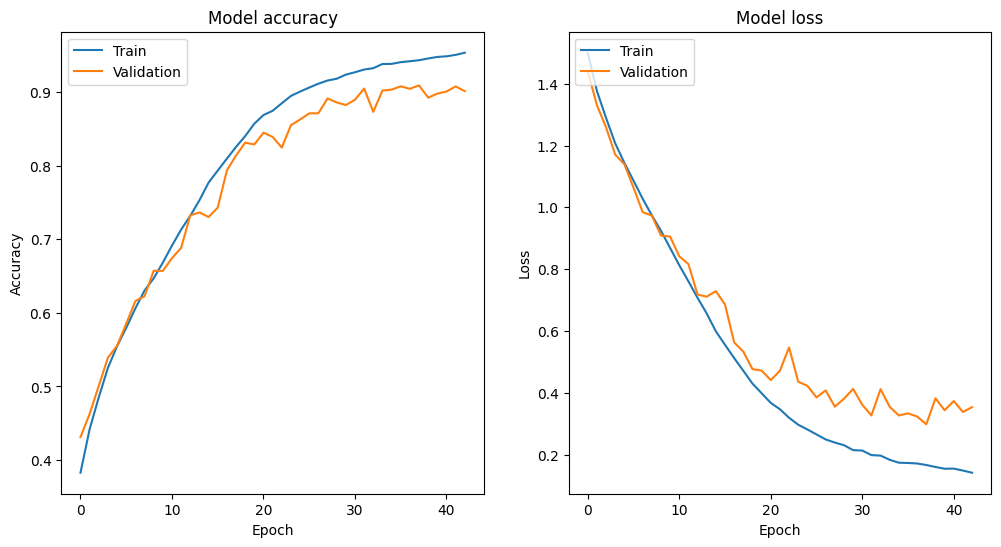

In [ ]:

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [ ]:
model.save('/content/drive/MyDrive/FYP/Speech_emotion_recognition/code /50K_best_gru_model.h5')

# GRU tuning

In [ ]:
def build_gru_model(hp):
    model = Sequential()

    # First GRU layer with variable units
    model.add(GRU(units=hp.Int('units_gru_1', min_value=32, max_value=512, step=32),
                  return_sequences=True, input_shape=(100, 65)))
    model.add(Dropout(hp.Float('dropout_gru_1', min_value=0.1, max_value=0.5, step=0.1)))

    # Second GRU layer with variable units
    model.add(GRU(units=hp.Int('units_gru_2', min_value=32, max_value=512, step=32)))
    model.add(Dropout(hp.Float('dropout_gru_2', min_value=0.1, max_value=0.5, step=0.1)))

    # Dense layer with variable units
    model.add(Dense(units=hp.Int('units_dense', min_value=32, max_value=512, step=32), activation='relu'))
    model.add(Dropout(hp.Float('dropout_dense', min_value=0.1, max_value=0.5, step=0.1)))

    # Output layer
    model.add(Dense(6, activation='softmax'))

    # Compile the model
    model.compile(
        optimizer=RMSprop(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

tuner = RandomSearch(
build_gru_model,
objective='val_accuracy',
max_trials=10,  # Number of different hyperparameter combinations to try
executions_per_trial=2,  # Number of models to build and fit for each trial
directory='my_dir',
project_name='gru_tuning')

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

tuner.search(
X_train, y_train,
epochs=30,
batch_size=128,
validation_data=(X_val, y_val),
callbacks=[early_stopping]
)



Trial 10 Complete [00h 03m 15s]
val_accuracy: 0.7027351260185242

Best val_accuracy So Far: 0.8517274260520935
Total elapsed time: 00h 40m 35s


In [ ]:
# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print(f'''
The hyperparameter search is complete. Here are the best hyperparameters:
- Units in the first GRU layer: {best_hps.get('units_gru_1')}
- Dropout rate for the first GRU layer: {best_hps.get('dropout_gru_1')}
- Units in the second GRU layer: {best_hps.get('units_gru_2')}
- Dropout rate for the second GRU layer: {best_hps.get('dropout_gru_2')}
- Units in the Dense layer: {best_hps.get('units_dense')}
- Dropout rate for the Dense layer: {best_hps.get('dropout_dense')}
- Learning rate: {best_hps.get('learning_rate')}
''')

# Build the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)

# Print a summary of the model
model.summary()

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=128,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Generate predictions and evaluate further
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)



report = classification_report(y_true_classes, y_pred_classes)
print(report)

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



The hyperparameter search is complete. Here are the best hyperparameters:
- Units in the first GRU layer: 32
- Dropout rate for the first GRU layer: 0.4
- Units in the second GRU layer: 480
- Dropout rate for the second GRU layer: 0.4
- Units in the Dense layer: 512
- Dropout rate for the Dense layer: 0.30000000000000004
- Learning rate: 0.0017491856822561972



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                          │ (None, 100, 32)             │           9,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 100, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_3 (GRU)                          │ (None, 480)                 │         740,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 480)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         246,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 999,014 (3.81 MB)

 Trainable params: 999,014 (3.81 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.3237 - loss: 1.6086 - val_accuracy: 0.4069 - val_loss: 1.4496
Epoch 2/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.4042 - loss: 1.4555 - val_accuracy: 0.3972 - val_loss: 1.4452
Epoch 3/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.4179 - loss: 1.4170 - val_accuracy: 0.4482 - val_loss: 1.3898
Epoch 4/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.4469 - loss: 1.3668 - val_accuracy: 0.4800 - val_loss: 1.3010
Epoch 5/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.4727 - loss: 1.3168 - val_accuracy: 0.4904 - val_loss: 1.2864
Epoch 6/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.4900 - loss: 1.2859 - val_accuracy: 0.5131 - val_loss: 1.2430
Epoch 7/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.5031 - loss: 1.2589 - val_accuracy: 0.5267 - val_loss: 1.2182
Epoch 8/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.5153 - loss: 1.2289 - val_accu

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')




326/326 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8869 - loss: 0.3450
Test Loss: 0.34899142384529114
Test Accuracy: 0.8851137161254883


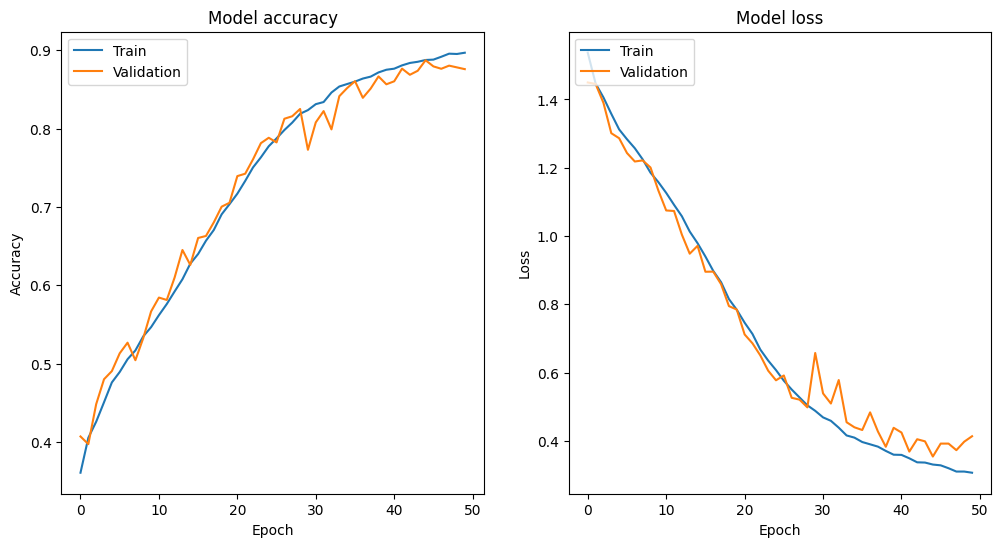

In [ ]:

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

326/326 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8845 - loss: 0.3725
Test Loss: 0.35186439752578735
Test Accuracy: 0.8856896162033081
326/326 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      1535
           1       0.90      0.87      0.89      1787
           2       0.83      0.89      0.86      1816
           3       0.89      0.89      0.89      1769
           4       0.89      0.82      0.85      1752
           5       0.93      0.92      0.93      1760

    accuracy                           0.89     10419
   macro avg       0.89      0.89      0.89     10419
weighted avg       0.89      0.89      0.89     10419



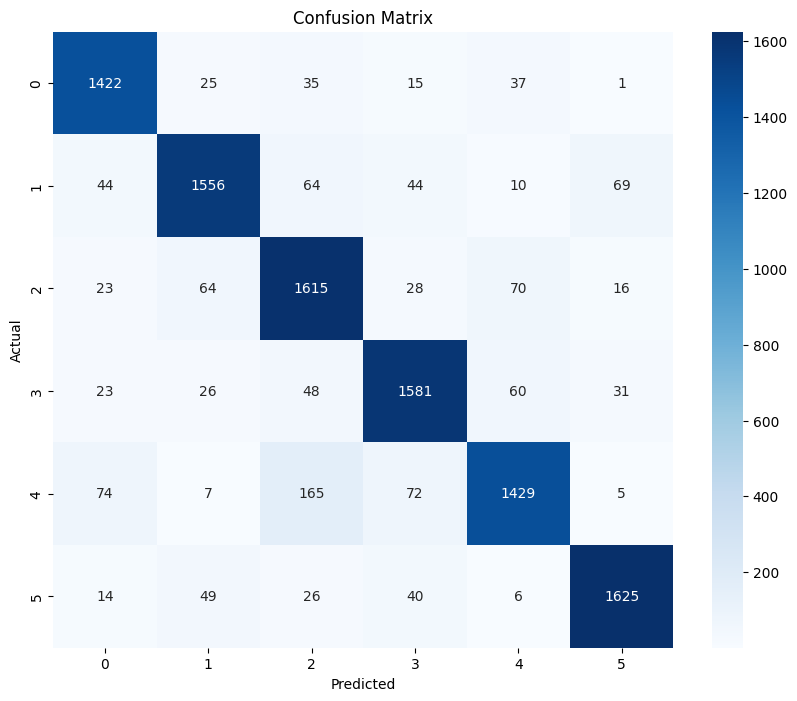

In [ ]:
# model = load_model('/content/drive/MyDrive/FYP/Speech_emotion_recognition/code /50K_best_gru_model.h5')


# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Generate predictions and evaluate further
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)



report = classification_report(y_true_classes, y_pred_classes)
print(report)

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# Testing

In [ ]:
!pip install resampy
# Load the saved model
# model = load_model('/content/drive/MyDrive/FYP/Speech_emotion_recognition/code /best_lstm_model.h5')
# model = load_model('/content/drive/MyDrive/FYP/Speech_emotion_recognition/code /best_cnn_model.h5')
# model = load_model('/content/drive/MyDrive/FYP/Speech_emotion_recognition/code /best_gru_model.h5')
model = load_model('/content/drive/MyDrive/FYP/Speech_emotion_recognition/code /50K_best_gru_model.h5')





# Function to preprocess a new .wav file without augmentation
def preprocess_audio(file_path, max_len=100):
    # Load the audio file
    audio, sample_rate = librosa.load(file_path, sr=22050)

    # Extract features: MFCC, Mel-Spectrogram, Chroma
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13)
    mel = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=40)
    chroma = librosa.feature.chroma_stft(y=audio, sr=sample_rate, n_chroma=12)

    # Truncate or pad the features to ensure consistent length
    def pad_or_truncate(feature, max_len):
        if feature.shape[1] > max_len:
            feature = feature[:, :max_len]  # Truncate
        else:
            pad_width = max_len - feature.shape[1]
            feature = np.pad(feature, pad_width=((0, 0), (0, pad_width)), mode='constant')  # Pad with zeros
        return feature

    mfccs = pad_or_truncate(mfccs, max_len)
    mel = pad_or_truncate(mel, max_len)
    chroma = pad_or_truncate(chroma, max_len)

    # Concatenate features along the first axis (feature axis)
    features = np.concatenate((mfccs, mel, chroma), axis=0)

    # Reshape to match the input shape expected by the model (number of timesteps, number of features)
    features = features.T  # Transpose to get (max_len, num_features)
    features = np.expand_dims(features, axis=0)  # Add batch dimension

    return features

# Function to predict emotion
def predict_emotion(model, file_path):
    # Preprocess the audio file
    features = preprocess_audio(file_path)

    # Make a prediction
    predictions = model.predict(features)

    # Get the predicted label (e.g., if using one-hot encoding)
    predicted_emotion = np.argmax(predictions)

    # Assuming you have a mapping from numerical labels to emotions
    emotion_mapping = {0: 'NEU', 1: 'HAP', 2: 'FEA', 3: 'DIS', 4:'SAD', 5:'ANG'}  # Example mapping

    return emotion_mapping[predicted_emotion]





In [ ]:

# Testing with a new .wav file
# file_path = '/content/drive/MyDrive/FYP/Crema/1001_DFA_ANG_XX.wav'
# file_path = '/content/drive/MyDrive/FYP/Crema/1001_DFA_SAD_XX.wav'
# file_path = '/content/drive/MyDrive/FYP/Crema/1002_IOM_FEA_XX.wav'
# file_path = '/content/drive/MyDrive/FYP/Crema/1001_IEO_HAP_LO.wav'
# file_path = '/content/drive/MyDrive/FYP/Crema/1001_ITS_DIS_XX.wav'
# file_path = '/content/drive/MyDrive/FYP/Crema/1001_ITH_NEU_XX.wav'
# file_path = '/content/drive/MyDrive/FYP/Speech_emotion_recognition/code /Record (online-voice-recorder.com).wav'
# file_path = '/content/drive/MyDrive/FYP/Speech_emotion_recognition/code /second.wav'


predicted_emotion = predict_emotion(model, file_path)

print(f'The predicted emotion is: {predicted_emotion}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
The predicted emotion is: SAD


# Deployment